# DATA EVALUATION

In [9]:
# IMPORTS + data loader function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


def load_dataset(path: str) -> dict:
    z = np.load(path)
    return {k: z[k] for k in z.files}

### Evaluation function

In [8]:
def evaluate_knn_over_k(
    data: dict,
    k_values,
    weights="uniform",
    metric="minkowski",
    n_jobs=None,
):
    """
    Läuft kNN für viele k-Werte durch und berechnet:
      - MSE gegen y_mean_test (die 'Wahrheit' / ideale Mittelwertfunktion)
      - MSE gegen y_test (noisy Beobachtungen) [optional aber oft interessant]

    Erwartet im data-Dict:
      X_train, y_train, X_test, y_test, y_mean_test
    """
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_test = data["X_test"]

    y_test = data.get("y_test", None)
    y_mean_test = data.get("y_mean_test", None)
    if y_mean_test is None:
        raise ValueError("Dataset enthält kein y_mean_test. Für 'gegen Wahrheit' brauchst du das.")

    results = {
        "k": [],
        "mse_vs_true_mean": [],
        "mse_vs_noisy_y": [],
    }

    for k in k_values:
        model = KNeighborsRegressor(
            n_neighbors=int(k),
            weights=weights,
            metric=metric,
            n_jobs=n_jobs,
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 1) Hauptmetrik: gegen die ideale Mittelwertfunktion
        mse_true = mean_squared_error(y_mean_test, y_pred)
        results["k"].append(int(k))
        results["mse_vs_true_mean"].append(float(mse_true))

        # 2) Optional: gegen noisy y_test (klassischer Test-MSE)
        if y_test is not None:
            mse_noisy = mean_squared_error(y_test, y_pred)
            results["mse_vs_noisy_y"].append(float(mse_noisy))
        else:
            results["mse_vs_noisy_y"].append(np.nan)

    return results

def summarize_results(results: dict, name: str):
    """
    Extrahiert bestes k (min MSE vs true mean) + zugehörige Fehler.
    """
    k = np.array(results["k"])
    mse_true = np.array(results["mse_vs_true_mean"])
    mse_noisy = np.array(results["mse_vs_noisy_y"])

    idx = np.argmin(mse_true)

    return {
        "dataset": name,
        "best_k": int(k[idx]),
        "min_mse_vs_true": float(mse_true[idx]),
        "mse_vs_noisy_at_best_k": float(mse_noisy[idx]),
    }

### PLOTS

In [4]:
def plot_mse_vs_k(results: dict, title: str):
    k = np.array(results["k"])
    mse_true = np.array(results["mse_vs_true_mean"])
    mse_noisy = np.array(results["mse_vs_noisy_y"])

    plt.figure()
    plt.plot(k, mse_true, marker="o", label="MSE vs true mean (y_mean_test)")
    if not np.all(np.isnan(mse_noisy)):
        plt.plot(k, mse_noisy, marker="o", label="MSE vs noisy y_test")

    plt.xscale("log")  # sinnvoll, weil k oft log-spaced ist
    plt.xlabel("k (log scale)")
    plt.ylabel("MSE")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_1d_knn_fits(data: dict, k_values, title: str):
    X_train = data["X_train"][:, 0]
    y_train = data["y_train"]
    X_test = data["X_test"][:, 0]
    y_mean_test = data["y_mean_test"]

    # Sortieren für Linien
    idx_test = np.argsort(X_test)
    Xs = X_test[idx_test]
    y_true = y_mean_test[idx_test]

    plt.figure()
    plt.scatter(X_train, y_train, alpha=0.35, s=12, label="train (noisy)")
    plt.plot(Xs, y_true, linewidth=2, label="true mean")

    for k in k_values:
        model = KNeighborsRegressor(n_neighbors=int(k))
        model.fit(data["X_train"], y_train)
        y_pred = model.predict(data["X_test"])[idx_test]
        plt.plot(Xs, y_pred, label=f"kNN k={k}")

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

### MAIN

                        dataset  best_k  min_mse_vs_true  \
0                  sine_1d_homo      30          0.00201   
1    piecewise_1d_hetero_linear      20          0.00690   
2          product_sine_5d_homo       8          0.01026   
3  linear_sum_10d_hetero_radial       8          0.15868   

   mse_vs_noisy_at_best_k  
0                 0.04316  
1                 0.09883  
2                 0.03175  
3                 0.23106  


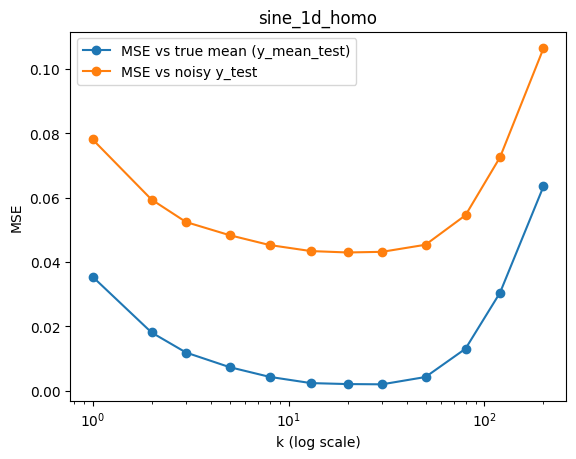

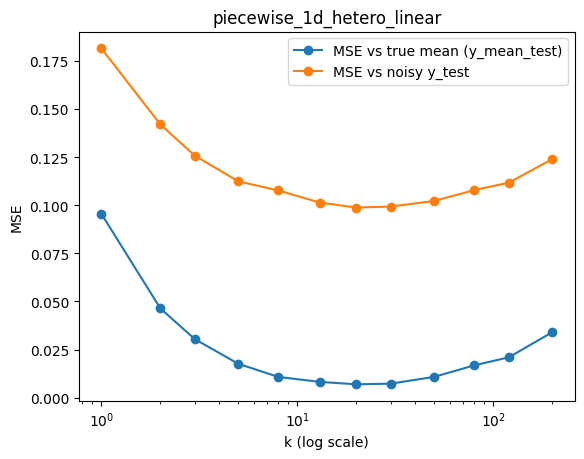

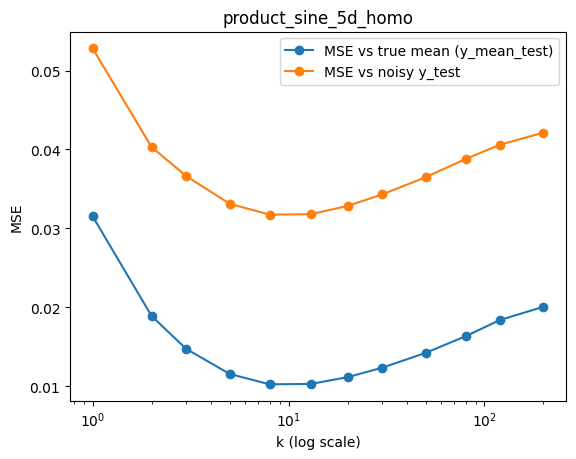

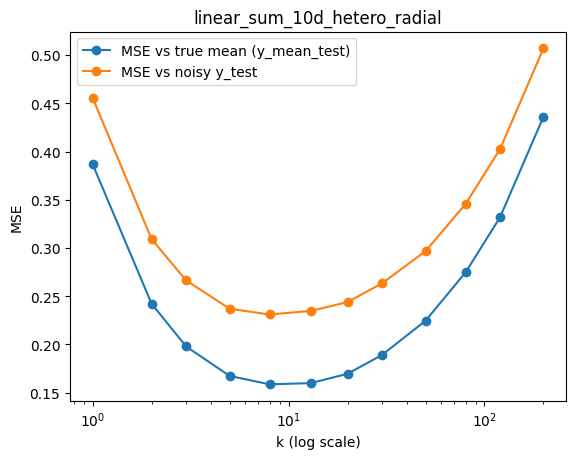

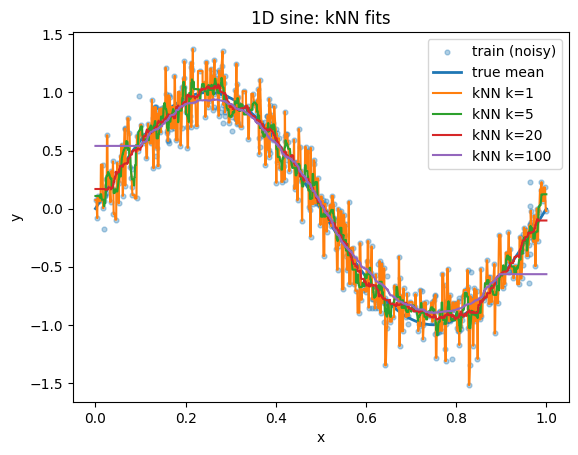

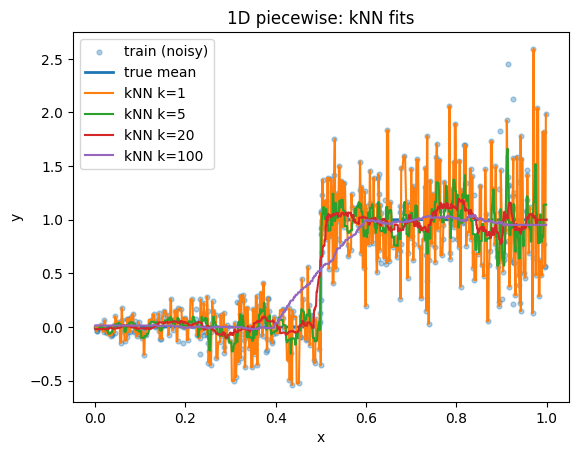

In [10]:
if __name__ == "__main__":
    sine = load_dataset("datasets/sine_1d_homo.npz")
    piecewise = load_dataset("datasets/piecewise_1d_hetero_linear.npz")
    product5d = load_dataset("datasets/product_sine_5d_homo.npz")
    linear10d = load_dataset("datasets/linear_sum_10d_hetero_radial.npz")

    k_values = [1, 2, 3, 5, 8, 13, 20, 30, 50, 80, 120, 200] # log spaced

    res_sine = evaluate_knn_over_k(sine, k_values)
    res_piecewise = evaluate_knn_over_k(piecewise, k_values)
    res_product5d = evaluate_knn_over_k(product5d, k_values)
    res_linear10d = evaluate_knn_over_k(linear10d, k_values)


    # Ergebnis Table
    rows = []
    rows.append(summarize_results(res_sine, "sine_1d_homo"))
    rows.append(summarize_results(res_piecewise, "piecewise_1d_hetero_linear"))
    rows.append(summarize_results(res_product5d, "product_sine_5d_homo"))
    rows.append(summarize_results(res_linear10d, "linear_sum_10d_hetero_radial"))

    df_summary = pd.DataFrame(rows)
    df_summary = df_summary.sort_values("min_mse_vs_true")

    df_summary["min_mse_vs_true"] = df_summary["min_mse_vs_true"].round(5)
    df_summary["mse_vs_noisy_at_best_k"] = df_summary["mse_vs_noisy_at_best_k"].round(5)
    print(df_summary)


    # plots
    plot_mse_vs_k(res_sine, "sine_1d_homo")
    plot_mse_vs_k(res_piecewise, "piecewise_1d_hetero_linear")
    plot_mse_vs_k(res_product5d, "product_sine_5d_homo")
    plot_mse_vs_k(res_linear10d, "linear_sum_10d_hetero_radial")
    plot_1d_knn_fits(sine, [1, 5, 20, 100], "1D sine: kNN fits")
    plot_1d_knn_fits(piecewise, [1, 5, 20, 100], "1D piecewise: kNN fits")